# Notebook to examine the temporal variability associated with numerical mixing 

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd

#Dask
from dask.distributed import Client

client = Client()
client

#Cartopy
land_10m = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                edgecolor='face',
                                facecolor=cfeature.COLORS['land'])

states_provinces = cfeature.NaturalEarthFeature(
                   category='cultural',
                   name='admin_1_states_provinces_lines',
                   scale='10m',
                   facecolor='none')

distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/dask-worker-space/worker-mqdoytbb', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/dask-worker-space/worker-m23h1d36', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/dask-worker-space/worker-zgbtdg89', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/dask-worker-space/worker-x7m2_htv', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/dask-worker-space/worker-278l8794', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/initial_submission/dask-worker-space/worker-wf3d7gwl', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES

In [2]:
# Open all output from 60 min, 30 min, 10 min frequency

#Tendency
ds2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/ds2dt_parent_ver1_2010.npy')
dsprime2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsprime2dt_ver1_parent_2010.npy')
dsbar2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsbar2dt_parent_ver1_2010.npy')
dsbarsprimedt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsbarsprimedt1_parent_ver1_2010.npy')

#Advection
s2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltsquareadv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltvaradv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbarsprime_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/2sbarsprime_advection_ver1_2010_*.nc')['2sbarprime_advection'].sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbar2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/sbar2_advection_ver1_2010_*.nc').sbar2_advection.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Surface
s2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/s2flux_ver1_2010_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/sprime2flux_ver1_2010_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
surface_extra = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/extra_ver1_2010_*.nc').surface_fluxes_extra.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Online resolved and numerical mixing
chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_ver1_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
chi_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_nested_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_nested_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_ver1_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Offline numerical mixing 
mnum_ss = -(ds2dt+s2_advection+chi_online-s2_surface)
mnum_sprime2 = -(dsprime2dt+sprime2_advection+chi_online-sprime2_surface)
mnum_diff = -dsbar2dt-dsbarsprimedt-sbarsprime_advection-sbar2_advection+surface_extra

#Define time for plotting
time = chi_online.ocean_time.values

#Volume-averaged salinity
sbar_parent = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/sbar/sbar_parent_ver1*.nc').sbar.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
s2_vavg = xr.open_dataset('/d2/home/dylan/JAMES/salt2_vavg.nc').salt2_vavg.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_vavg = xr.open_dataset('/d2/home/dylan/JAMES/sprime2_vavg.nc').sprime2_vavg.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#30 minutes -----------------
ds2dt_30 = np.load('/d2/home/dylan/JAMES/budget_outputs/30min/tendency/ds2dt_parent_2010_30min.npy')
dsprime2dt_30 = np.load('/d2/home/dylan/JAMES/budget_outputs/30min/tendency/dsprime2dt_parent_2010_30min.npy')
dsbar2dt_30 = np.load('/d2/home/dylan/JAMES/budget_outputs/30min/tendency/dsbar2dt_parent_2010_30min.npy')
dsbarsprimedt_30 = np.load('/d2/home/dylan/JAMES/budget_outputs/30min/tendency/dsbarsprimedt1_parent_2010_30min.npy')

s2_advection_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/advection/saltsquareadv_parent_2010_30min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/advection/saltvaradv_parent_2010_30min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbarsprime_advection_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/advection/2sbarsprime_advection_2010_30min_*.nc')['2sbarprime_advection'].sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbar2_advection_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/advection/sbar2_advection_2010_30min_*.nc').sbar2_advection.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

s2_surface_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/surface_fluxes/s2flux_2010_30min_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/surface_fluxes/sprime2flux_2010_30min_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
surface_extra_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/surface_fluxes/extra_2010_30min_*.nc').surface_fluxes_extra.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

chi_online_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/mixing/chi_online_2010_30min_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/mixing/mnum_online_2010_30min_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

mnum_ss_30 = -(ds2dt_30+s2_advection_30+chi_online_30-s2_surface_30)
mnum_sprime2_30 = -(dsprime2dt_30+sprime2_advection_30+chi_online_30-sprime2_surface_30)
mnum_diff_30 = -dsbar2dt_30-dsbarsprimedt_30-sbarsprime_advection_30-sbar2_advection_30+surface_extra_30

time_30 = chi_online_30.ocean_time.values

sbar_parent_30 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/30min/sbar/sbar_parent_2010_30min_*.nc').sbar.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#10 minutes ---------------
ds2dt_10 = np.load('/d2/home/dylan/JAMES/budget_outputs/10min/ds2dt_parent_2010_10min.npy')
dsprime2dt_10 = np.load('/d2/home/dylan/JAMES/budget_outputs/10min/dsprime2dt_parent_2010_10min.npy')
dsbar2dt_10 = np.load('/d2/home/dylan/JAMES/budget_outputs/10min/dsbar2dt_parent_2010_10min.npy')
dsbarsprimedt_10 = np.load('/d2/home/dylan/JAMES/budget_outputs/10min/dsbarsprimedt1_parent_2010_10min.npy')

s2_advection_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/advection/saltsquareadv_parent_2010_10min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/advection/saltvaradv_parent_2010_10min_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbarsprime_advection_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/advection/2sbarsprime_advection_2010_10min_*.nc')['2sbarprime_advection'].sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbar2_advection_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/advection/sbar2_advection_2010_10min_*.nc').sbar2_advection.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

s2_surface_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/surface_fluxes/s2flux_2010_10min_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/surface_fluxes/sprime2flux_2010_10min_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
surface_extra_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/surface_fluxes/extra_2010_10min_*.nc').surface_fluxes_extra.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

chi_online_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/mixing/chi_online_2010_10min_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/mixing/mnum_online_2010_10min_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

mnum_ss_10 = -(ds2dt_10+s2_advection_10+chi_online_10-s2_surface_10)
mnum_sprime2_10 = -(dsprime2dt_10+sprime2_advection_10+chi_online_10-sprime2_surface_10)
mnum_diff_10 = -dsbar2dt_10-dsbarsprimedt_10-sbarsprime_advection_10-sbar2_advection_10+surface_extra_10

time_10 = chi_online_10.ocean_time.values

sbar_parent_10 = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/10min/sbar/sbar_parent_2010_10min_*.nc').sbar.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

Text(0, 0.5, '[(g kg$^{-1}$)$^2$]')

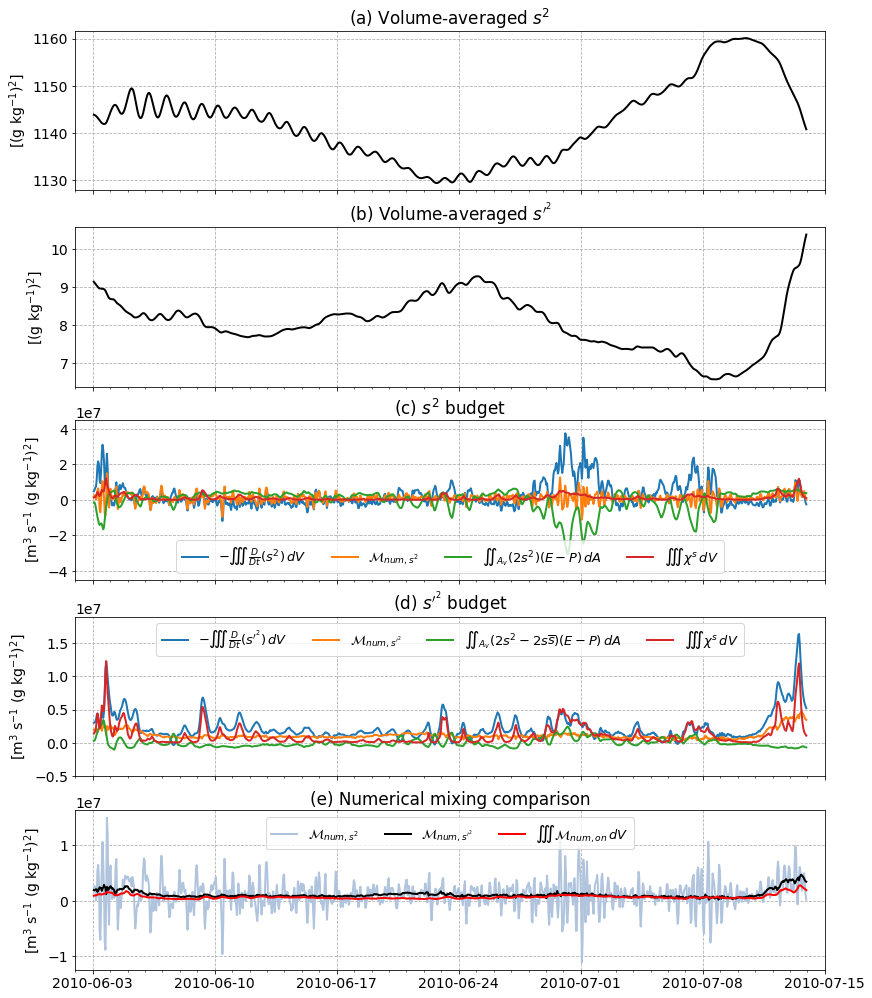

In [ ]:
s2_material = ds2dt+s2_advection
sprime2_material = dsprime2dt+sprime2_advection

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(5,1, figsize = (12,2.75*5), constrained_layout = True, sharey = False)

ax[0].plot(time, s2_vavg, color = 'k', lw = 2)
ax[0].set_xticklabels([])
ax[0].set_title('(a) Volume-averaged $s^2$')

ax[1].plot(time, sprime2_vavg, color = 'k', lw = 2)
ax[1].set_xticklabels([])
ax[1].set_title('(b) Volume-averaged $s^{\prime^2}$')

ax[2].plot(time, -s2_material, lw = 2, label = r'$-\iiint \frac{D}{Dt}(s^2) \, dV$')
ax[2].plot(time, mnum_ss, lw = 2, label = r'$\mathcal{M}_{num, s^2}$')
ax[2].plot(time, s2_surface, lw = 2, label = r'$\iint_{A_v} (2s^2)(E-P) \, dA$')
ax[2].plot(time, chi_online, lw = 2, label = r'$\iiint \chi^s \, dV$')

ax[2].set_ylim(-4.5e7,4.5e7)
ax[2].set_title(r'(c) $s^2$ budget')
ax[2].legend(loc = 'lower center', ncol = 4, fontsize = 13)
ax[2].set_xticklabels([])

ax[3].plot(time, -sprime2_material, lw = 2, label = r'$-\iiint \frac{D}{Dt}(s^{\prime^2}) \, dV$')
ax[3].plot(time, mnum_sprime2, lw = 2, label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[3].plot(time, sprime2_surface, lw = 2, label = r'$\iint_{A_v} (2s^2-2s \overline{s})(E-P) \, dA$')
ax[3].plot(time, chi_online, lw = 2, label = r'$\iiint \chi^s \, dV$')
ax[3].set_ylim(-.5e7,1.9e7)
ax[3].set_title(r'(d) $s^{\prime^2}$ budget')
ax[3].legend(loc = 'upper center', ncol = 4, fontsize = 13)
ax[3].set_xticklabels([])

ax[4].plot(time, mnum_ss, color = 'lightsteelblue', lw = 2, label = r'$\mathcal{M}_{num, s^2}$')
ax[4].plot(time, mnum_sprime2, lw = 2, color = 'k', label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[4].plot(time, mnum_online, lw = 2, color = 'r', label = '$\iiint \mathcal{M}_{num, on} \, dV$')
ax[4].set_title('(e) Numerical mixing comparison')
ax[4].legend(loc = 'upper center', ncol = 3, fontsize = 13)
# bbox_to_anchor=(1.0, 1.02)
#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
for i in range(5):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid(linestyle = '--')
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
ax[i].set_xlabel('')
for i in range(4):
    ax[i].set_xticklabels([])

ax[0].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[1].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
# plt.savefig('/d2/home/dylan/JAMES/figures/draft1/budget_comparison_material.jpg', dpi = 300, bbox_inches='tight')

# Check to make sure the difference between $\iiint \mathcal{M}_{num, on} \, dV$ and $\mathcal{M}_{num, s^2}$ isn't because of horizontal mixing 

In [6]:
#Horizontal mixing
path = '/d2/home/dylan/JAMES/budget_outputs/mixing/chi_horizontal_parent_2010_*.nc'
hmix = xr.open_mfdataset(path).chi_horizontal

/tmp/ipykernel_2993/2117289941.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(dates, rotation = 0)


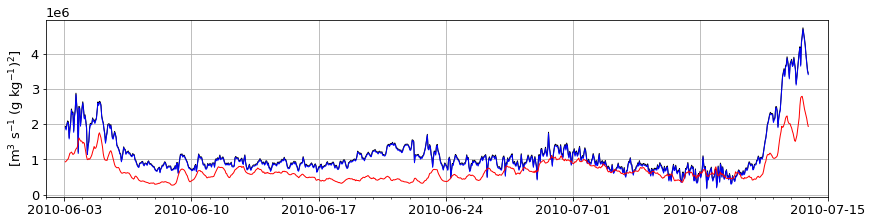

In [9]:
plt.rcParams.update({'font.size': 13})

fig, ax = plt.subplots(1,1, figsize = (12,3), constrained_layout = True, sharey = False)

ax.plot(time, mnum_sprime2, lw = 1, color = 'k', label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax.plot(time, mnum_sprime2-hmix, lw = 1, color = 'b', label = r'$\mathcal{M}_{num, s^{\prime^2}}$-hmix')
ax.plot(time, mnum_online, lw = 1, color = 'r', label = '$\iiint \mathcal{M}_{num, on} \, dV$')


#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
ax.set_xticklabels(dates, rotation = 0)
ax.xaxis.set_major_formatter(myFmt)
ax.set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax.set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax.set_xticks(ticks = dates, rotation = 0)
ax.grid()
ax.xaxis.set_minor_locator(mdates.DayLocator())

# Good - so no noticeable difference if horizontal mixing is included. Move onto extra terms in the $s^2$ budget 

Text(0, 0.5, '[g kg$^{-1}$]')

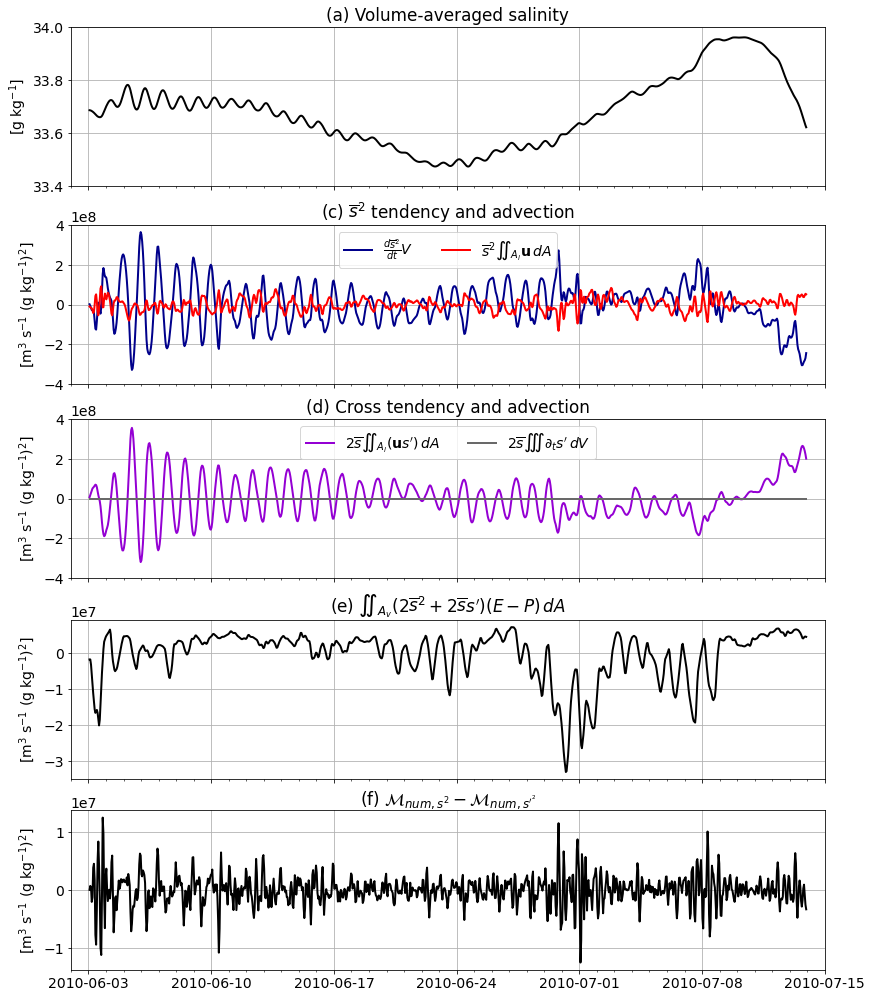

In [10]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(5,1, figsize = (12,2.75*5), constrained_layout = True, sharey = False)

ax[0].plot(time, sbar_parent, color = 'k', lw = 2)
ax[0].set_ylim(33.4, 34)
ax[0].set_title('(a) Volume-averaged salinity')

ax[1].plot(time, dsbar2dt, lw = 2, color = 'darkblue', label = r'$\frac{d\overline{s}^2}{dt}V$')
ax[1].plot(time, sbar2_advection, lw = 2, color = 'r', label = r'$\overline{s}^2 \iint_{A_l} \mathbf{u} \, dA$')
ax[1].legend(loc = 'upper center', ncol = 2)
ax[1].set_title(r'(c) $\overline{s}^2$ tendency and advection')
ax[1].set_ylim(-4e8,4e8)

ax[2].plot(time, sbarsprime_advection, color = 'darkviolet', lw = 2, label = r'$2\overline{s} \iint_{A_l} (\mathbf{u}s^{\prime}) \, dA$')
ax[2].plot(time, dsbarsprimedt, color = 'dimgrey', lw = 2, label = r'$2\overline{s}\iiint \partial_t s^\prime \, dV$')
ax[2].legend(loc = 'upper center', ncol = 2)
ax[2].set_title(r'(d) Cross tendency and advection')
ax[2].set_ylim(-4e8,4e8)

ax[3].plot(time, surface_extra, lw = 2, color = 'k')
ax[3].set_title(r'(e) $\iint_{A_v} (2 \overline{s}^2+2\overline{s}s^\prime)(E-P) \, dA$')

ax[4].plot(time, mnum_diff, lw = 2, color = 'k')
ax[4].set_title(r'(f) $\mathcal{M}_{num, s^2} - \mathcal{M}_{num, s^{\prime^2}}$')

for i in range(5):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid()
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    
for i in range(4):
    ax[i].set_xticklabels([])
# ax[i+1].set_xlabel('Time [month-day 2010]')

ax[0].set_ylabel('[g kg$^{-1}$]')
# plt.savefig('/d2/home/dylan/JAMES/figures/draft1/extra_terms.jpg', dpi = 300, bbox_inches='tight')

# Next, discussion figure on model output frequency

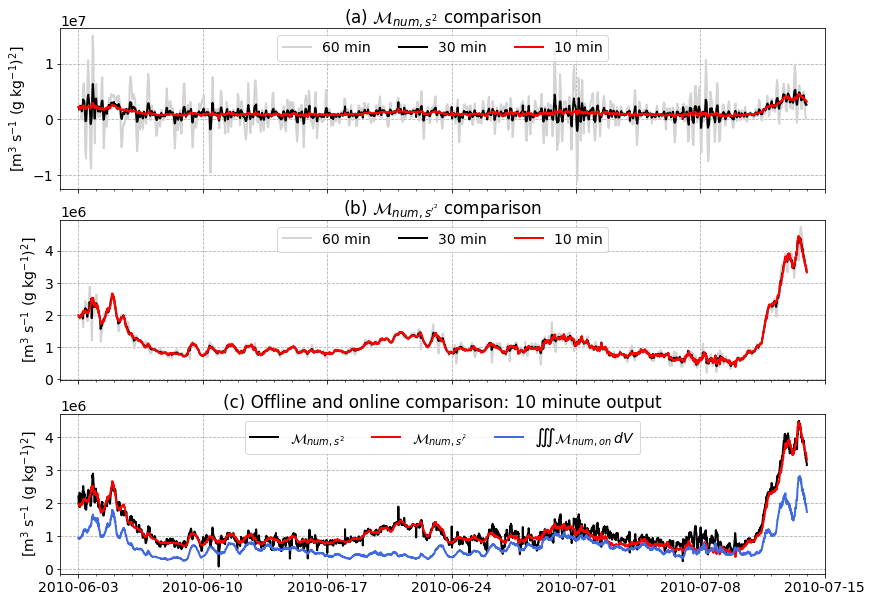

In [18]:
plt.rcParams.update({'font.size': 14})

#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]

fig, ax = plt.subplots(3,1, figsize = (12,2.75*3), constrained_layout = True, sharey = False)

ax[0].plot(time, mnum_ss, lw = 2, c = 'lightgrey', label = r'60 min')
ax[0].plot(time_30, mnum_ss_30, lw = 2, c = 'k', label = r'30 min')
ax[0].plot(time_10, mnum_ss_10, lw = 2, c = 'r', label = r'10 min')
# ax[0].plot(time_10, mnum_online_10, lw = 2, color = 'm', label = r'$M_{num, on}}$ 10 min')
ax[0].set_title('(a) $\mathcal{M}_{num, s^2}$ comparison')
ax[0].legend(loc = 'upper center', ncol = 4)

ax[0].xaxis.set_major_formatter(myFmt)
ax[0].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].set_xticks(ticks = dates)
ax[0].grid(linestyle = '--')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])

ax[1].plot(time, mnum_sprime2, lw = 2, color = 'lightgrey', label = r'60 min')
ax[1].plot(time_30, mnum_sprime2_30, lw = 2, color = 'k', label = r'30 min')
ax[1].plot(time_10, mnum_sprime2_10, lw = 2, color = 'r', label = r'10 min')
# ax[1].plot(time_10, mnum_online_10, lw = 2, color = 'm', label = r'$M_{num, on}}$ 10 min')
ax[1].set_title(r'(b) $\mathcal{M}_{num, s^{\prime^2}}$ comparison')
ax[1].legend(loc = 'upper center', ncol = 4)

ax[1].xaxis.set_major_formatter(myFmt)
ax[1].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[1].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[1].grid(linestyle = '--')
ax[1].set_xticklabels([])
ax[1].set_xticks(ticks = dates)

ax[2].plot(time_10, mnum_ss_10, lw = 2, color = 'k', label = r'$\mathcal{M}_{num, s^2}$')
ax[2].plot(time_10, mnum_sprime2_10, lw = 2, color = 'r', label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[2].plot(time_10, mnum_online_10, lw = 2, color = 'royalblue', label = '$\iiint \mathcal{M}_{num, on} \, dV$')
ax[2].set_title(r'(c) Offline and online comparison: 10 minute output')
ax[2].legend(loc = 'upper center', ncol = 3)

ax[2].xaxis.set_major_formatter(myFmt)
ax[2].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
ax[2].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[2].set_xticks(ticks = dates)
ax[2].grid(linestyle = '--')
# ax[2].set_xlabel('Time [month-day 2010]')

for i in range(3):
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    
plt.savefig('/d2/home/dylan/JAMES/figures/draft1/temporal_resolution_budgets.jpg', dpi = 300, bbox_inches='tight')

# Investigate whether the tendency and advection terms contribute to the difference between the 10- and 30-minute output 

In [11]:
s2_material = ds2dt+s2_advection
s2_material_30 = ds2dt_30+s2_advection_30
s2_material_10 = ds2dt_10+s2_advection_10

print(np.corrcoef(s2_material_10, mnum_ss_10))
print(np.corrcoef(s2_material_30, mnum_ss_30))
print(np.corrcoef(s2_material, mnum_ss))

[[ 1.         -0.15284878]
 [-0.15284878  1.        ]]
[[ 1.        -0.1461947]
 [-0.1461947  1.       ]]
[[ 1.        -0.3314665]
 [-0.3314665  1.       ]]


In [12]:
time_30[:100]-time_10[3:-3][::3][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='timedelta64[ns]')

In [13]:
test = -((ds2dt_30-ds2dt_10[3:-3][::3])+(s2_advection_30-s2_advection_10[3:-3][::3]))
test1 = -((ds2dt_30-ds2dt_10[3:-3][::3]))
test2 = np.linspace(-4e6, 4e6, 100)
test3 = (s2_advection_30-s2_advection_10[3:-3][::3])

In [18]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

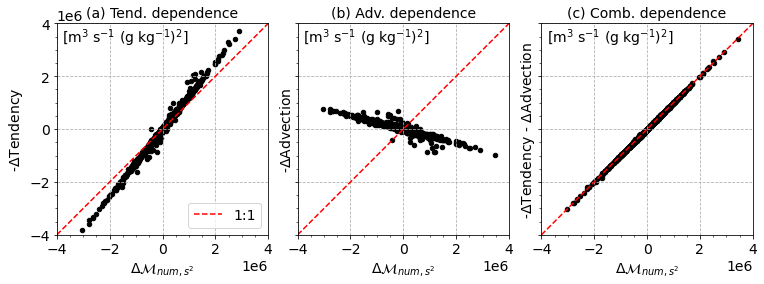

In [22]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1,3, figsize = (6*1.75,9*1.75), constrained_layout = True, sharey = True, sharex = True)

ax[0].plot(test2, test2, c = 'r', ls = '--', label = '1:1')
p1 = ax[0].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], test1, c = 'k', s = 20)
ax[0].set_ylim(-4e6, 4e6)
ax[0].set_xlim(-4e6, 4e6)

ax[0].set_ylabel(r'-$\Delta$Tendency')
ax[0].set_title(r'(a) Tend. dependence', fontsize = 14)
ax[0].legend(loc = 'lower right')
ax[0].ticklabel_format(useOffset=False, axis='both')

ax[1].plot(test2, test2, c = 'r', ls = '--')
ax[1].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], -test3, c = 'k', s = 20)
ax[1].set_xlabel('')
ax[1].set_ylabel(r'-$\Delta$Advection')
ax[1].set_title(r'(b) Adv. dependence', fontsize = 14)

ax[2].plot(test2, test2, c = 'r', ls = '--')
ax[2].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], test, c = 'k', s = 20)
ax[2].set_ylabel(r'-$\Delta$Tendency - $\Delta$Advection')
ax[2].set_title(r'(c) Comb. dependence', fontsize = 14)

for i in range(3):
    ax[i].grid(linestyle = '--')
    ax[i].set_aspect('equal')
    ax[i].set_xlabel(r'$\Delta \mathcal{M}_{num, s^2}$', fontsize = 14)
    ax[i].text(-3.8e6, 3.3e6, r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]', fontsize = 14)
ax[2].xaxis.set_minor_locator(MultipleLocator(.5e6))
ax[2].yaxis.set_minor_locator(MultipleLocator(.5e6))

plt.savefig('/d2/home/dylan/JAMES/figures/draft1/discussion_term_balance.jpg', dpi = 300, bbox_inches='tight')

In [ ]:
# Now pl

In [19]:
#Times directly after the the restart process occurs, remove these 
timedrop = [np.datetime64('2010-06-18T18:30:00.000000000'), 
            np.datetime64('2010-06-19T18:30:00.000000000'), 
            np.datetime64('2010-07-09T18:30:00.000000000'),
            np.datetime64('2010-07-09T19:30:00.000000000')]

chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_ver1_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chi_online = chi_online.chi_online.where((chi_online.ocean_time!= timedrop[0])
                                             & (chi_online.ocean_time!= timedrop[1])
                                             & (chi_online.ocean_time!= timedrop[2])
                                             & (chi_online.ocean_time!= timedrop[3]),
                                             drop=False)

mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_ver1_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_online = mnum_online.mnum_online.where((mnum_online.ocean_time!= timedrop[0])
                                             & (mnum_online.ocean_time!= timedrop[1])
                                             & (mnum_online.ocean_time!= timedrop[2])
                                             & (chi_online.ocean_time!= timedrop[3]),
                                             drop=False)

chi_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_nested_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
chi_online_child = chi_online_child.chi_online.where((chi_online_child.ocean_time!= timedrop[0])
                                             & (chi_online_child.ocean_time!= timedrop[1])
                                             & (chi_online_child.ocean_time!= timedrop[2])
                                             & (chi_online.ocean_time!= timedrop[3]),
                                             drop=False)
mnum_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_nested_2010_*.nc').sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_online_child = mnum_online_child.mnum_online.where((mnum_online_child.ocean_time!= timedrop[0])
                                             & (mnum_online_child.ocean_time!= timedrop[1])
                                             & (mnum_online_child.ocean_time!= timedrop[2])
                                             & (chi_online.ocean_time!= timedrop[3]),
                                             drop=False)

#Second step - select only parent times where child output is available
chi_online = chi_online.where(chi_online_child.ocean_time==chi_online.ocean_time)
mnum_online = mnum_online.where(mnum_online_child.ocean_time==mnum_online.ocean_time)

mtotal_parent = chi_online+mnum_online
mtotal_child = chi_online_child+mnum_online_child

In [20]:
# Basic statistics and percent change of the different ratios 
r1 = chi_online_child/chi_online
r2 = mnum_online_child/mnum_online
r3 = mtotal_child/mtotal_parent
r4 = mnum_online/chi_online
r5 = chi_online_child.mean().values/chi_online.mean().values
r6 = mnum_online_child.mean().values/mnum_online.mean().values
r7 = mtotal_child.mean().values/mtotal_parent.mean().values
r8 = mnum_online.mean().values/chi_online.mean().values
print(r1.mean().values)
print(r2.mean().values)
print(r3.mean().values)
print(r4.mean().values)
print(r5)
print(r6)
print(r7)
print(r8)
print((mnum_online/mtotal_parent).mean().values)
print((mnum_online_child/mtotal_child).mean().values)

1.5092189323118217
0.6694107336166369
1.0606618067272795
1.7336339340883795
1.3713478411633313
0.6452934759358744
1.104434754684001
0.5813310604681055


In [25]:
def per_change(final, initial):
    perchange = 100*((final-initial)/np.abs(initial))
    return perchange

per_change(chi_online_child.mean().values, chi_online.mean().values)

37.13478411633313

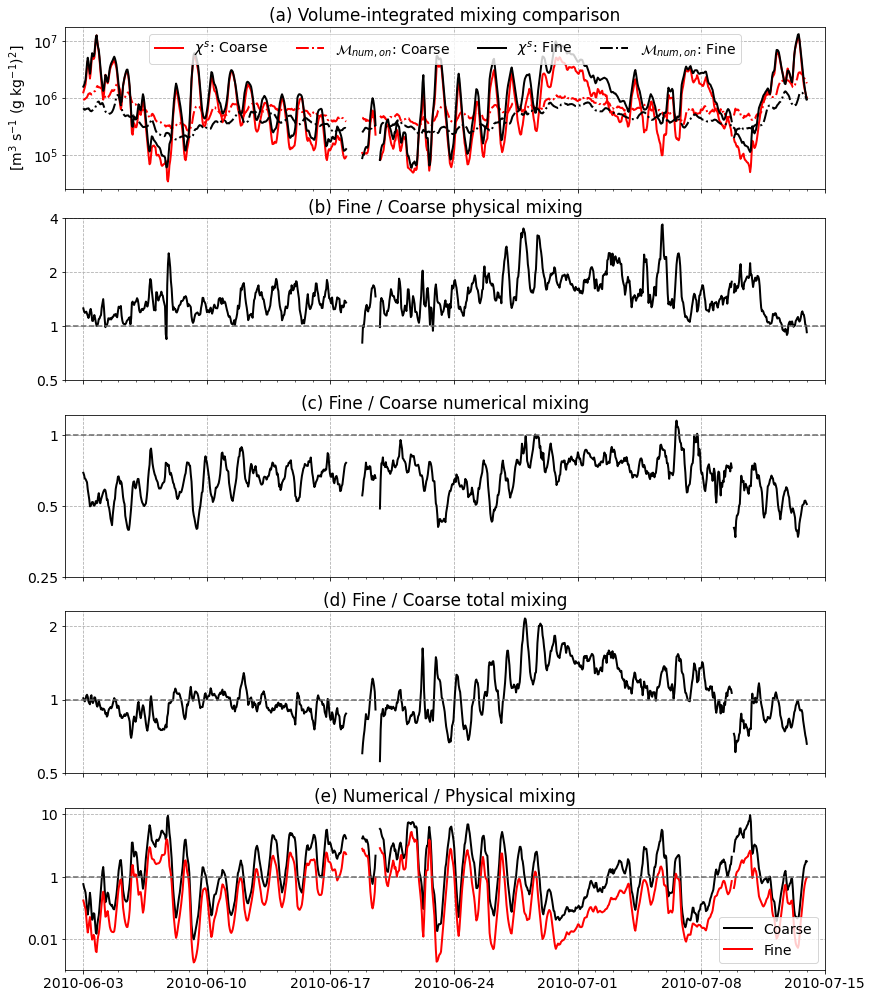

In [22]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(5,1, figsize = (12,2.75*5), constrained_layout = True, sharey = False)

ax[0].plot(r1.ocean_time, chi_online, lw = 2, color = 'r', label = r'$\chi^s$: Coarse')
ax[0].plot(r1.ocean_time, mnum_online, lw = 2, color = 'r', ls = '-.', label = r'$\mathcal{M}_{num, on}$: Coarse')
ax[0].plot(r1.ocean_time, chi_online_child, lw = 2, color = 'k', label = r'$\chi^s$: Fine')
ax[0].plot(r1.ocean_time, mnum_online_child, lw = 2, color = 'k', ls = '-.', label = r'$\mathcal{M}_{num, on}$: Fine')
ax[0].set_yscale("log")
ax[0].set_yticks([10**5, 10**6, 10**7])
ax[0].legend(ncol = 4, loc = 'upper center')
ax[0].minorticks_off()

ax[0].set_title('(a) Volume-integrated mixing comparison')

ax[1].plot(r1.ocean_time, np.log10(r1), lw = 2, c = 'k')
ax[1].set_title('(b) Fine / Coarse physical mixing')
ax[1].set_ylabel('')
ax[1].minorticks_off()
ax[1].set_yticks([-0.30103, 0, 0.30103, 0.60206])
ax[1].set_yticklabels([1/2, 1, 2, 4])

ax[2].plot(r1.ocean_time, np.log10(r2), lw = 2, c = 'k')
ax[2].set_title('(c) Fine / Coarse numerical mixing')
ax[2].set_ylabel('')
ax[2].minorticks_off()
ax[2].set_yticks([-0.60206, -0.30103, 0, ])
ax[2].set_yticklabels([1/4, 1/2, 1])

ax[3].plot(r1.ocean_time, np.log10(r3), lw = 2, c = 'k')
ax[3].set_title('(d) Fine / Coarse total mixing')
ax[3].minorticks_off()
ax[3].set_yticks([-0.30103, 0, 0.30103])
ax[3].set_yticklabels([1/2, 1, 2])

ax[4].plot(r1.ocean_time, np.log10(r4), lw = 2, c = 'k', label = 'Coarse')
ax[4].plot(r1.ocean_time, np.log10(mnum_online_child/chi_online_child), lw = 2, c = 'r', label = 'Fine')
ax[4].set_title('(e) Numerical / Physical mixing')
ax[4].set_ylabel('')
ax[4].set_yticks([-1, 0, 1])
ax[4].set_yticklabels([0.01, 1, 10])
ax[4].legend()

myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
for i in range(5):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xticks(ticks = dates)
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    
for i in range(4):
    ax[i].set_xticklabels([])
    ax[i].set_xlabel('')
    ax[i].grid(linestyle = '--')
    ax[i].set_ylabel('')
ax[i+1].grid(linestyle = '--')
ax[i+1].set_xlabel('')
# ax[i+1].set_xlabel('Time [month-day 2010]')

for i in range(3):
    ax[i+1].axhline(y = 0, ls = '--', c = 'dimgrey')
ax[4].axhline(y = 0, ls = '--', c = 'dimgrey')
plt.setp(ax[3].xaxis.get_majorticklabels(), rotation=0)

ax[0].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
plt.savefig('/d2/home/dylan/JAMES/figures/draft1/mixing_comparison_time_series.jpg', dpi = 300, bbox_inches='tight')

# Earlier iterations of the discussion code - just haven't deleted this yet.

In [7]:
s2_material = ds2dt+s2_advection
s2_material_30 = ds2dt_30+s2_advection_30
s2_material_10 = ds2dt_10+s2_advection_10

print(np.corrcoef(s2_material_10, mnum_ss_10))
print(np.corrcoef(s2_material_30, mnum_ss_30))
print(np.corrcoef(s2_material, mnum_ss))

In [8]:
print(np.corrcoef(s2_material_10, mnum_ss_10))
print(np.corrcoef(s2_material_30, mnum_ss_30))
print(np.corrcoef(s2_material, mnum_ss))

[[ 1.         -0.15284878]
 [-0.15284878  1.        ]]
[[ 1.        -0.1461947]
 [-0.1461947  1.       ]]
[[ 1.        -0.3314665]
 [-0.3314665  1.       ]]


# Correlation between numerical mixing and tendency doesn't yield anything interesting. Let's try plotting the difference in tendency term between the 10 minute output and 30 minute output

In [9]:
print(len(time_10[::3]))
print(len(time_30))

1968
1966


In [10]:
time_30[:100]-time_10[3:-3][::3][:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype='timedelta64[ns]')

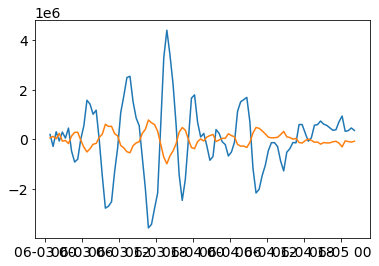

In [11]:
plt.plot(time_10[3:-3][::3][:100], ds2dt_10[3:-3][::3][:100]-ds2dt_30[:100])
plt.plot(time_10[3:-3][::3][:100], s2_advection_10[3:-3][::3][:100]-s2_advection_30[:100])

In [12]:
test = -((ds2dt_30-ds2dt_10[3:-3][::3])+(s2_advection_30-s2_advection_10[3:-3][::3]))
test1 = -((ds2dt_30-ds2dt_10[3:-3][::3]))
test2 = np.linspace(-4e6, 4e6, 100)
test3 = (s2_advection_30-s2_advection_10[3:-3][::3])

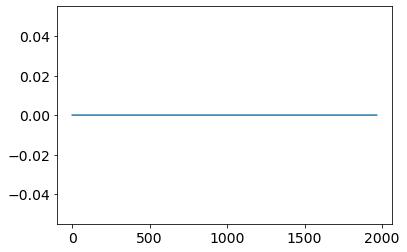

In [13]:
test = -((ds2dt_30-ds2dt_10[3:-3][::3])+(s2_advection_30-s2_advection_10[3:-3][::3]))
test4 = (-(ds2dt_30-ds2dt_10[3:-3][::3])-(s2_advection_30-s2_advection_10[3:-3][::3]))

plt.plot(test-test4)
# plt.plot(test4)

In [18]:
r1 = np.corrcoef(test1, mnum_ss_30-mnum_ss_10[3:-3][::3])
r2 = np.corrcoef(-test3, mnum_ss_30-mnum_ss_10[3:-3][::3])
r3 = np.corrcoef(test, mnum_ss_30-mnum_ss_10[3:-3][::3])
print(r1)
print(r2)
print(r3)

[[1.         0.99740977]
 [0.99740977 1.        ]]
[[ 1.         -0.94790777]
 [-0.94790777  1.        ]]
[[1.         0.99988002]
 [0.99988002 1.        ]]


In [19]:
np.corrcoef(mnum_ss_30-mnum_ss_10[3:-3][::3], -test3)

array([[ 1.        , -0.94790777],
       [-0.94790777,  1.        ]])

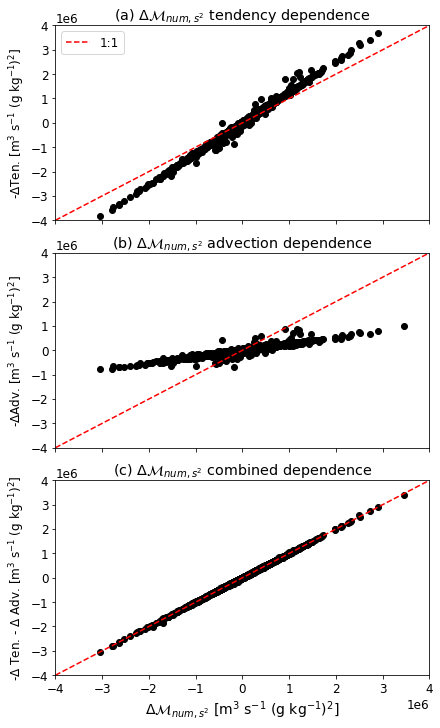

In [15]:
plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1, figsize = (6,10), constrained_layout = True, sharey = True, sharex = True)

ax[0].plot(test2, test2, c = 'r', ls = '--', label = '1:1')
ax[0].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], test1, c = 'k')
ax[0].set_ylim(-4e6, 4e6)
ax[0].set_xlim(-4e6, 4e6)
ax[0].set_xlabel('')
ax[0].set_ylabel(r'-$\Delta$Ten. [m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[0].set_title(r'(a) $\Delta \mathcal{M}_{num, s^2}$ tendency dependence')
ax[0].legend()

ax[1].plot(test2, test2, c = 'r', ls = '--')
ax[1].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], test3, c = 'k')
ax[1].set_xlabel('')
ax[1].set_ylabel(r'-$\Delta$Adv. [m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[1].set_title(r'(b) $\Delta \mathcal{M}_{num, s^2}$ advection dependence')

ax[2].plot(test2, test2, c = 'r', ls = '--')
ax[2].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], test, c = 'k')
ax[2].set_ylabel(r'-$\Delta$ Ten. - $\Delta$ Adv. [m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[2].set_xlabel('$\Delta \mathcal{M}_{num, s^2}$ [m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]', fontsize = 14)
ax[2].set_title(r'(c) $\Delta \mathcal{M}_{num, s^2}$ combined dependence')
plt.savefig('/d2/home/dylan/JAMES/figures/draft1/discussion_term_balance.jpg', dpi = 300, bbox_inches='tight')

# Remake this so that there is a grid and everything is horizontal 

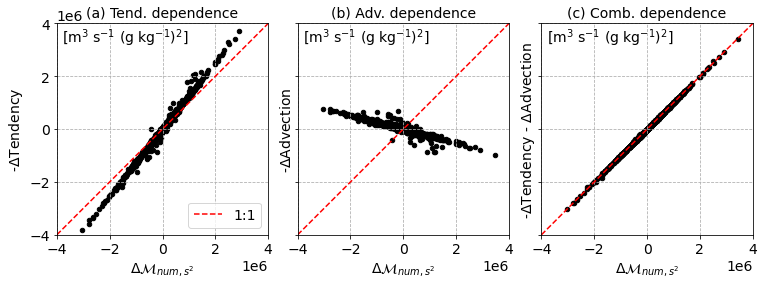

In [25]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(1,3, figsize = (6*1.75,9*1.75), constrained_layout = True, sharey = True, sharex = True)

ax[0].plot(test2, test2, c = 'r', ls = '--', label = '1:1')
p1 = ax[0].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], test1, c = 'k', s = 20)
ax[0].set_ylim(-4e6, 4e6)
ax[0].set_xlim(-4e6, 4e6)

ax[0].set_ylabel(r'-$\Delta$Tendency')
ax[0].set_title(r'(a) Tend. dependence', fontsize = 14)
ax[0].legend(loc = 'lower right')
ax[0].ticklabel_format(useOffset=False, axis='both')

ax[1].plot(test2, test2, c = 'r', ls = '--')
ax[1].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], -test3, c = 'k', s = 20)
ax[1].set_xlabel('')
ax[1].set_ylabel(r'-$\Delta$Advection')
ax[1].set_title(r'(b) Adv. dependence', fontsize = 14)

ax[2].plot(test2, test2, c = 'r', ls = '--')
ax[2].scatter(mnum_ss_30-mnum_ss_10[3:-3][::3], test, c = 'k', s = 20)
ax[2].set_ylabel(r'-$\Delta$Tendency - $\Delta$Advection')
ax[2].set_title(r'(c) Comb. dependence', fontsize = 14)

for i in range(3):
    ax[i].grid(linestyle = '--')
    ax[i].set_aspect('equal')
    ax[i].set_xlabel(r'$\Delta \mathcal{M}_{num, s^2}$', fontsize = 14)
    ax[i].text(-3.8e6, 3.3e6, r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]', fontsize = 14)

plt.savefig('/d2/home/dylan/JAMES/figures/draft1/discussion_term_balance.jpg', dpi = 300, bbox_inches='tight')

In [5]:
test = -((ds2dt_30-ds2dt_10[3:-3][::3])+(s2_advection_30-s2_advection_10[3:-3][::3]))
test1 = -((ds2dt_30-ds2dt_10[3:-3][::3]))
test2 = np.linspace(-4e6, 4e6, 100)
test3 = (s2_advection_30-s2_advection_10[3:-3][::3])

In [6]:
t = sum(mnum_ss_30.values-mnum_ss_10[3:-3][::3].values)
t1 = sum(test.values)

In [7]:
np.average(test1/(mnum_ss_30-mnum_ss_10[3:-3][::3]))

1.3679441072727077

In [8]:
np.average(test3/(mnum_ss_30-mnum_ss_10[3:-3][::3]))

0.36520847988799177

In [9]:
np.average(test.values/(mnum_ss_30-mnum_ss_10[3:-3][::3]))

1.002735627384716

In [10]:
np.average(1-(test.values/(mnum_ss_30-mnum_ss_10[3:-3][::3])))*100

-0.27356273847160023

In [13]:
np.average(test/((mnum_ss_30-mnum_ss_10[3:-3][::3])))

1.002735627384716